In [190]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score

In [191]:
df = pd.read_csv('combined_df.csv')

In [192]:
df['morning_appt'] = df['appointment_time'].apply(lambda x: 1 if x.lower() == 'morning' else 0)
df.drop(columns = ['appointment_time', 'Unnamed: 0'], inplace = True)

X = df.drop(columns=['morning_appt'])
y = df['morning_appt']

categorical_cols = ['intake_method', 'referer', 'age', 'appointment_location']
numeric_cols = ['Medication_Management', 'Talk_Therapy']

In [193]:
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
X_encoded.head()

,Medication_Management,Talk_Therapy,intake_method_Boom Form,intake_method_Call,intake_method_Other,intake_method_Text,intake_method_Unknown,intake_method_Virtual,intake_method_Waitlist,referer_Alison D'Mello,...,age_40-50,age_50-60,age_60-70,age_70-80,age_80-90,age_Other,age_Unknown,appointment_location_Princeton,appointment_location_Unknown,appointment_location_Virtual
0,0,1,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,0,1,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,0,1,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,1,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,1,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [194]:
X_encoded.columns

Index(['Medication_Management', 'Talk_Therapy', 'intake_method_Boom Form',
       'intake_method_Call', 'intake_method_Other', 'intake_method_Text',
       'intake_method_Unknown', 'intake_method_Virtual',
       'intake_method_Waitlist', 'referer_Alison D'Mello',
       'referer_Bariatric Doctor', 'referer_Client of Alexis',
       'referer_Client of Alyssa', 'referer_Client of Ariella',
       'referer_Client of Marissa', 'referer_Community Event',
       'referer_Current Client', 'referer_Facebook', 'referer_Family/Friend',
       'referer_Flyer', 'referer_Following Clinician',
       'referer_Google Referral', 'referer_Google or another search engine',
       'referer_HLOC', 'referer_Healthcare Provider', 'referer_Hospital',
       'referer_IOP', 'referer_Insurance Company',
       'referer_Internal TOL Referral', 'referer_Internal TOL Referral ',
       'referer_Neuro Testing Evaluation', 'referer_Non-Profit Organization',
       'referer_Other', 'referer_Outpatient Therapy Practi

In [195]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=1234, stratify=y
)

In [217]:
# Class Imbalance
y.value_counts()/df.shape[0]

,count
morning_appt,
0,0.753933
1,0.246067


Class Imbalance
- 75% = 0
- 25% = 1
- scale_pos_weight = 0.75/0.25 = 3

In [196]:
model = XGBClassifier(
    scale_pos_weight=3,
    eval_metric="logloss",
    n_estimators = 5,
    max_depth = 6
)
# model.fit(X_train, y_train)

Grid Search to test different hyperparameters:

In [197]:
param_grid = {
    'n_estimators': [5, 10, 50, 100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 10],
}

In [198]:
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='recall',   # good for imbalanced data
    cv=5,
    n_jobs=-1,
    verbose=2
)

In [199]:
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best recall:", grid.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 5}
Best recall: 0.9284505552617661


In [200]:
model = XGBClassifier(
    scale_pos_weight=3,
    eval_metric="logloss",
    learning_rate = grid.best_params_['learning_rate'],
    n_estimators = grid.best_params_['n_estimators'],
    max_depth = grid.best_params_['max_depth']
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=5, n_jobs=None,
              num_parallel_tree=None, ...)

In [201]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print("Accuracy for test set:", accuracy_score(y_test, y_pred))
print("Accuracy for train set:", accuracy_score(y_train, y_pred_train))

Accuracy for test set: 0.45318352059925093
Accuracy for train set: 0.42776886035313


In [202]:
# Evaluate the model with precision, recall, and F1-score
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Calculate ROC AUC Score (requires binary or one-vs-all approach for multi-class)
roc_auc = roc_auc_score(
    y_test,
    model.predict(X_test)
)
print(f"ROC AUC Score: {roc_auc:.2f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.31      0.46       403
           1       0.30      0.91      0.45       131

    accuracy                           0.45       534
   macro avg       0.60      0.61      0.45       534
weighted avg       0.76      0.45      0.46       534

ROC AUC Score: 0.61


In [203]:
importances = model.feature_importances_
feature_names = X_encoded.columns

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fi_df.head(15)

,feature,importance
8,intake_method_Waitlist,0.482225
48,age_10-20,0.253586
47,referer_Unknown,0.111035
0,Medication_Management,0.090888
4,intake_method_Other,0.031648
23,referer_HLOC,0.030617
5,intake_method_Text,0.000000
3,intake_method_Call,0.000000
7,intake_method_Virtual,0.000000
9,referer_Alison D'Mello,0.000000


/tmp/ipython-input-486623107.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(fi_df['feature'][:10], rotation = 90)


Text(0, 0.5, 'Normalized importance')

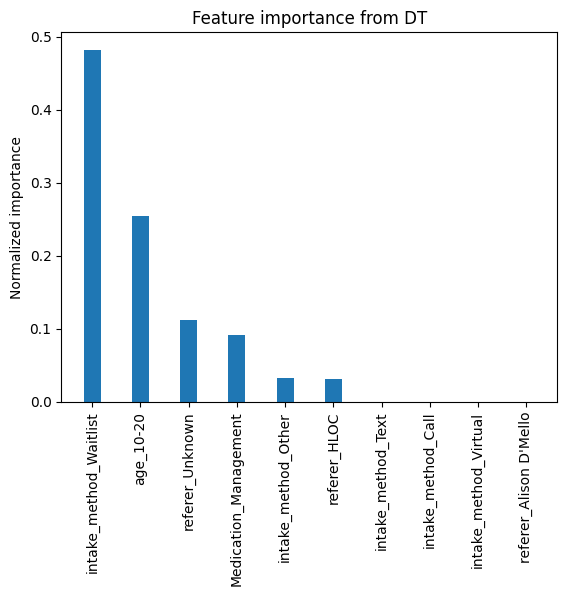

In [204]:
fig, ax = plt.subplots()

ax.bar(fi_df['feature'][:10], fi_df['importance'][:10], width = 0.35)
#ax.set_xticks(np.arange(10))
ax.set_xticklabels(fi_df['feature'][:10], rotation = 90)
plt.title('Feature importance from Gradient Boosting')
ax.set_ylabel('Normalized importance')

### Using f1_score for scaling

In [205]:
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',   # good for imbalanced data
    cv=5,
    n_jobs=-1,
    verbose=2
)

In [206]:
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best f1 score:", grid.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10}
Best f1 score: 0.4447470290503702


In [207]:
model = XGBClassifier(
    scale_pos_weight=3,
    eval_metric="logloss",
    learning_rate = grid.best_params_['learning_rate'],
    n_estimators = grid.best_params_['n_estimators'],
    max_depth = grid.best_params_['max_depth']
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, ...)

In [208]:
pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print("Accuracy for test set:", accuracy_score(y_test, y_pred))
print("Accuracy for train set:", accuracy_score(y_train, y_pred_train))

Accuracy for test set: 0.45318352059925093
Accuracy for train set: 0.42776886035313


In [209]:
# Evaluate the model with precision, recall, and F1-score
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Calculate ROC AUC Score (requires binary or one-vs-all approach for multi-class)
roc_auc = roc_auc_score(
    y_test,
    model.predict(X_test)
)
print(f"ROC AUC Score: {roc_auc:.2f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.31      0.46       403
           1       0.30      0.91      0.45       131

    accuracy                           0.45       534
   macro avg       0.60      0.61      0.45       534
weighted avg       0.76      0.45      0.46       534

ROC AUC Score: 0.61


In [210]:
importances = model.feature_importances_
feature_names = X_encoded.columns

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fi_df.head(15)

,feature,importance
8,intake_method_Waitlist,0.424916
48,age_10-20,0.219828
47,referer_Unknown,0.135958
0,Medication_Management,0.089520
4,intake_method_Other,0.034736
24,referer_Healthcare Provider,0.034600
49,age_20-30,0.031513
23,referer_HLOC,0.028929
3,intake_method_Call,0.000000
9,referer_Alison D'Mello,0.000000


/tmp/ipython-input-1994746521.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(fi_df['feature'][:10], rotation = 90)


Text(0, 0.5, 'Normalized importance')

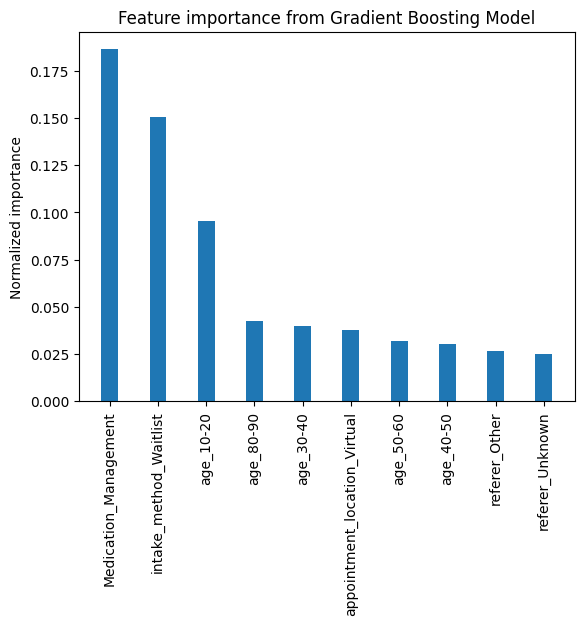

In [218]:
fig, ax = plt.subplots()

ax.bar(fi_df['feature'][:10], fi_df['importance'][:10], width = 0.35)
#ax.set_xticks(np.arange(10))
ax.set_xticklabels(fi_df['feature'][:10], rotation = 90)
plt.title('Feature importance from Gradient Boosting Model')
ax.set_ylabel('Normalized importance')

## Regular Gradient Boosting

In [212]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
model.fit(X_train, y_train)

GradientBoostingClassifier()

In [213]:
# Evaluate the model with precision, recall, and F1-score
y_pred = model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Calculate ROC AUC Score (requires binary or one-vs-all approach for multi-class)
roc_auc = roc_auc_score(
    y_test,
    model.predict(X_test)
)
print(f"ROC AUC Score: {roc_auc:.2f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.98      0.86       403
           1       0.46      0.05      0.08       131

    accuracy                           0.75       534
   macro avg       0.61      0.51      0.47       534
weighted avg       0.69      0.75      0.67       534

ROC AUC Score: 0.51


In [214]:
importances = model.feature_importances_
feature_names = X_encoded.columns

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fi_df.head(15)

,feature,importance
0,Medication_Management,0.186389
8,intake_method_Waitlist,0.150603
48,age_10-20,0.095530
55,age_80-90,0.042450
50,age_30-40,0.039618
60,appointment_location_Virtual,0.037755
52,age_50-60,0.031807
51,age_40-50,0.030257
32,referer_Other,0.026359
47,referer_Unknown,0.024807


/tmp/ipython-input-486623107.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(fi_df['feature'][:10], rotation = 90)


Text(0, 0.5, 'Normalized importance')

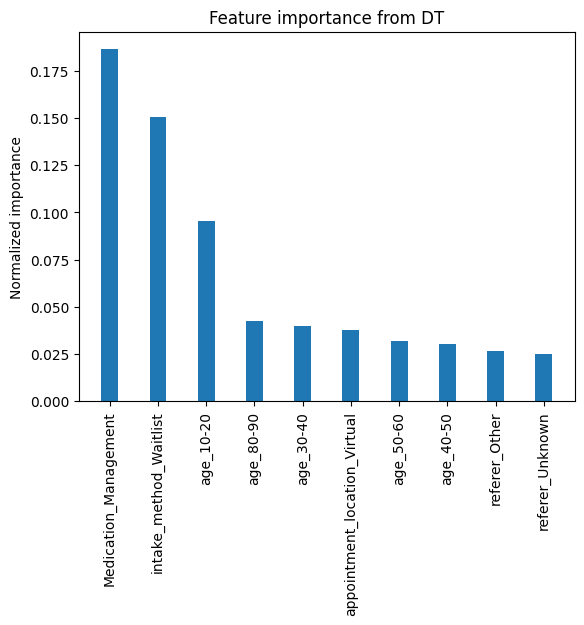

In [215]:
fig, ax = plt.subplots()

ax.bar(fi_df['feature'][:10], fi_df['importance'][:10], width = 0.35)
#ax.set_xticks(np.arange(10))
ax.set_xticklabels(fi_df['feature'][:10], rotation = 90)
plt.title('Feature importance from DT')
ax.set_ylabel('Normalized importance')